# K-Nearest Neighbors

When a prediction is required, the k-most similar records to a new record from the training dataset are located. From these neighbors, a summarized prediction is made.

### 3 Steps

1. Calculate the distance between two rows in a dataset.

2. Get nearest neighbors: Calculate the distance between each record in the dataset to the new piece of data. Then, sort all of the records in the training dataset by their distance to the new data and return the top k.

3. Make predictions: return the most represented value among the neighbors.

# Predicting Housing Prices

### Loading in Packages and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
style.use('ggplot')

data_dir = '/Users/sam/Desktop/Portfolio Projects/Predicting Housing Prices/Data/'

# Data is from Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques
train = pd.read_csv(data_dir + 'train.csv', index_col = 0)
test = pd.read_csv(data_dir + 'test.csv', index_col = 0)
sample = pd.read_csv(data_dir + 'sample_submission.csv', index_col = 0)

### Cleaning Data

Many of the variables include values that are strings. In order for the algorithm to measure the impact on the overal housing price these variables values must be encoded to be integers.

In [2]:
def train_encode(x):
    train_vars = list(train.select_dtypes(include = ['category', 'object']))
    
    for i in train_vars:
        train[i] = train[i].astype('category').cat.codes
    return train

def test_encode(x):
    test_vars = list(test.select_dtypes(include=['category','object']))
    
    for i in test_vars:
        test[i] = test[i].astype('category').cat.codes
    return test

train = train_encode(train)
test = test_encode(test)
test = test.merge(sample, on = 'Id')

### Splitting into Train and Test Datasets

In [3]:
X_train = train.iloc[:, :-1].fillna(-1)  # the encoded variables replace missing values with -1

y_train = train['SalePrice']

X_test = test.iloc[:, :-1].fillna(-1)

y_test = test['SalePrice']

# Make sure they are all the same length or else the algorithm won't run
print('X_train Shape:', X_train.shape, '|', 'y_train Shape:',y_train.shape,'|','X_test Shape:', X_test.shape,'|',
      'y_test Shape:', y_test.shape)

X_train Shape: (1460, 79) | y_train Shape: (1460,) | X_test Shape: (1459, 79) | y_test Shape: (1459,)


### Predicting the Prices with  K-Nearest Neighbors

In [4]:
knn = KNeighborsRegressor(n_neighbors = 5) # default is minkowski distance (p=2) which is the same as Euclidean
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_actual = y_test

y_pred = pd.DataFrame(y_pred)
y_actual = pd.DataFrame(y_actual)

data = [y_actual, y_pred]

concat = pd.concat(data)

concat[0] = concat[0].shift(-len(y_pred))

data = concat.dropna()
data = data.rename(columns = {'SalePrice' : 'Actual Value',
                   0 : 'Predicted Value'})

data = data.reset_index()
data = data.rename(columns = {'index' : 'ID'})
data = data.sort_values(by = 'ID')
data.to_csv(data_dir + 'knn_results.csv', index = False)

### Plotting Predicted vs. Actual Values

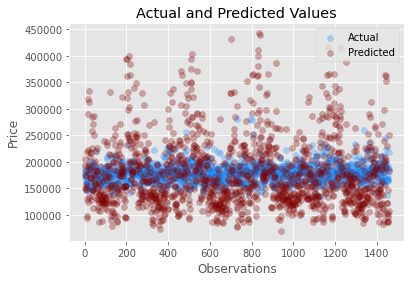

In [5]:
y_actual = data['Actual Value']
y_pred = data['Predicted Value']

fig, ax = plt.subplots()
ax.scatter(x = range(0, y_actual.size), y = y_actual, c = 'dodgerblue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y = y_pred, c = 'maroon', label = 'Predicted', alpha = 0.3)

plt.title('Actual and Predicted Values')
plt.xlabel('Observations')
plt.ylabel('Price')
plt.legend()
plt.show()

### Measuring the Accuracy

Using root mean squared error (RMSE), mean absolute error (MAE), and mean absolute percentage error (MAPE). 
1. RMSE is the square root of the variance of the residuals. It measures how close the actual values are to the model's predicted values. RMSE gives a relatively high weight to large errors, therefore penalizing them more than MAE. Lower values of RMSE indicate better fit.

2. MAE measures on average, how big of an error we can expect from the predicted value. It gives equal weight to all individual differences between the actual and predicted values.

3. Accuracy (MAPE) is MAE in percentage form. With an accuracy score of 75% this means on average, we can expect a 25% error from the predicted value.

By comparing RMSE to MAE we are able to determine whether to predicted values contain large but infrequent errors. The larger the difference between RMSE and MAE the more inconsistent the error size. 

In [10]:
def mean_absolute_percentage_error(y_actual, y_pred): 
    y_actual, y_pred = np.array(y_actual), np.array(y_pred)
    mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
    return mape

rmse = mean_squared_error(y_actual, y_pred)**.5
mae = mean_absolute_error(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred)
accuracy = 100 - np.mean(mape)

print('RMSE: $', round(rmse, 2))
print('MAE: $', round(mae, 2))
print('Accuracy:', round(accuracy, 2), '%')

RMSE: $ 58403.51
MAE: $ 44641.56
Accuracy: 75.03 %


### Conclusion

On average, KNN model was able to predict the sale price of a house within \\$44,641.